In [1]:
import tkinter as tk
from dragonfly import maximise_function, minimise_function
import socket
import struct
import numpy as np
import time
import re
import threading
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import (FigureCanvasTkAgg, NavigationToolbar2Tk)

#import classes from other files
import sys
sys.path.append("functions")
from functions_rest import GUI
#from functions_opt import OPT
from functions_hexapod import *
from functions_cam import *

udp_client = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
client = socket.socket(socket.AF_INET, socket.SOCK_STREAM)

C:\Users\loasis\AppData\Local\Programs\Python\Python37-32\lib\site-packages\dragonfly\utils\oper_utils.py:30: UserWarning: cannot import name 'direct' from 'dragonfly.utils.direct_fortran' (C:\Users\loasis\AppData\Local\Programs\Python\Python37-32\lib\site-packages\dragonfly\utils\direct_fortran\__init__.py)
Could not import Fortran direct library. Dragonfly can still be used, but might be slightly slower. To get rid of this warning, install a numpy compatible Fortran compiler (e.g. gfortran) and the python-dev package and reinstall Dragonfly.
  warn('%s\n%s'%(e, fortran_err_msg))


We are done here:
2.7100000000000364
[-2.2105  2.0505 -0.5894 -0.2472]
We are done here:
4.769999999999868
[-2.213   2.048  -0.5869 -0.2397]


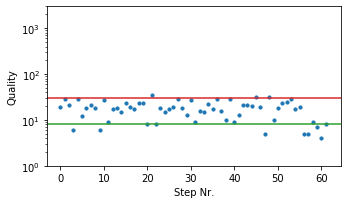

In [2]:
root = tk.Tk()
my_gui = GUI(root)
root.mainloop()